## Case: Fraud detection in energy consumption

**Objective:** Evaluate the current prediction score of electricity consumption fraud and implement a model that can surpass the current model.

I divided the notebook into the following sections:

- **Importing:** Importing libraries and dataset
- **Utils:** Functions used during the analysis
- **Sanity check:** Checking whether that are any inconsistencies in the dataset
- **Cost matrix:** Assigning custom costs for each value
- **Checking current model:** Evaluating the current prediction 
- **EDA:** Analyzing the dataset description of each group
- **Feature Engineering:** Creating new features
- **Modeling:** Applying different models to optimize costs
    - **Classification:** Applying simple classifiers
    - **Tuning classifiers:** Applying selected simple classifiers and tuning hyperparameters
    - **Anomaly detection:** Applying proper algorithms for anomaly detection
    - **LSTM:** Applying Long Short Term Memory 
- **Results:** Conclusion of the most suitable model to minimize costs

## Importing

In [27]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import backend as K

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [28]:
df = pd.read_csv('Fraude Eletricidade/electricity thief.csv')

# selects only columns that contains 'consumption'
consumption_cols = [c for c in df.columns if 'Consumption' in c]

## Utils

In [29]:
# cost function
def average_cost(y_test, y_pred, cost):
    c = confusion_matrix(y_test,y_pred)
    score = np.sum(c*cost)/np.sum(c)
    return score

In [30]:
# plot confusion matrix given the true target and predicted 
def plot_confusion_matrix(y_test, y_pred, title='Confusion matrix'):    
    cm = confusion_matrix(y_test, y_pred)
    classes = ['No Fraud', 'Fraud']
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# replace the target values by integer    
def dataprep_target(df, target='Inspection Results'):
    target_map = {'No Fraud': 0, 'Fraud': 1}
    return df[target].map(target_map)

# change the threshold of probabilities prediction and calculate the classification metrics and cost for each prediction 
def change_threshold(y_true, y_prob, cost):
    thresholds = np.arange(0.1, 1.0, 0.1)                
    plt.figure(figsize=(10,10))

    j = 1
    for i in thresholds:
        i = round(i, 1)
        y_pred = np.where(y_prob >= i, 1, 0)

        plt.subplot(4, 3, j)
        j += 1

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true,y_pred)
        np.set_printoptions(precision=2)
        
        acc = round(accuracy_score(y_true, y_pred), 2)
        rec = round(recall_score(y_true, y_pred), 2)
        pre = round(precision_score(y_true, y_pred), 2)
        auc = round(roc_auc_score(y_true, y_pred), 2)
        cos = round(average_cost(y_true, y_pred, cost), 2)

        print(f"Threshold: {i} | Roc Auc: {auc:5} | Accuracy: {acc:5} | Recall: {rec:5} | Precision: {pre:5} | Avg cost: {cos}")

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(y_true, y_pred, title=f'Threshold >= {round(i, 1)}')
    plt.show()
           
# split the dataset into train and test
def dataprep_split(df, target='Inspection Results', random_state=42):
    x = df.drop(target, axis=1)
    y = df[target]
    return train_test_split(x, y, stratify=y, test_size=0.3, random_state=random_state)

In [31]:
# filter column given its value
def dataprep_filter_col(df, col, value):
    print(f'Filtering: {col:8} - {value}')
    return df[df[col] == value].drop(col, axis=1)

# plot countplot for the current probability score and target
def plot_countplots(df, x='Fraud Probability Rate', y='Inspection Results'):    
    f = plt.figure(figsize=(14, 2))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    sns.countplot(data=df, y=y, ax=ax1)
    sns.countplot(data=df, x=x, hue=y, ax=ax2)
    plt.show()

# split the dataset for each target    
def dataprep_split_fraud(df, consumption_cols=consumption_cols):    
    df_fraud = df[df['Inspection Results'] == 'Fraud'][consumption_cols]
    df_nfraud = df[df['Inspection Results']  == 'No Fraud'][consumption_cols]
    df_fraud.columns = df_nfraud.columns = np.arange(12, 0, -1)
    df_fraud = df_fraud.T.sort_index()
    df_nfraud = df_nfraud.T.sort_index()
    return df_fraud, df_nfraud

# normalize the dataset by row or column
def dataprep_normalize(df, scale_row=None):
    minmax_scale = MinMaxScaler()
    if scale_row == True:
        df_norm = pd.DataFrame(minmax_scale.fit_transform(df.T).T, columns=df.columns, index=df.index)
    else:
        df_norm = pd.DataFrame(minmax_scale.fit_transform(df), columns=df.columns, index=df.index)
    return df_norm

# plot line or boxplot for each month
def plot_months(df_fraud, df_nfraud, kind=None, title='Raw Data'):
    print(f'<============ {title} ============>')
    fig, axs = plt.subplots(1, 2, sharey=True)        
    if kind == 'box':        
        df_fraud.T.plot(kind=kind, figsize=(15, 3), ax=axs[0], legend=False, title='Fraud')
        df_nfraud.T.plot(kind=kind, ax=axs[1], legend=False, title='No fraud')        
    else:
        df_fraud.plot(figsize=(15, 4), ax=axs[0], legend=False, title='Fraud')
        df_nfraud.plot(ax=axs[1], legend=False, title='No fraud')
    plt.show()

# plot heatmap for each aggregation function
def plot_heatmap_agg(df, agg_func, consumption_cols=consumption_cols):
    try:
        print(f'Aggregation function: {agg_func}')
        plt.figure(figsize=(16, 3))
        df_group = df.groupby('Inspection Results')[consumption_cols].agg(agg_func).astype('int')  
        df_group.columns = np.arange(12, 0, -1)    
        df_group = df_group[df_group.columns[::-1]]

        sns.heatmap(df_group, annot=True, cmap='YlGnBu', linewidths=.5, fmt='d')
        plt.ylabel('')
        plt.yticks(rotation=0)
        plt.xticks(rotation=45)
        plt.show()
    except:
        pass

# gather plottings and description for each group
def plot_full_description(df=df, col_loc=None, col_cla=None, col_pha=None,
                          consumption_cols=consumption_cols, target='Inspection Results'):
    
    if col_loc is not None:
        df = dataprep_filter_col(df, 'Location', col_loc)
    if col_cla is not None:
        df = dataprep_filter_col(df, 'Class', col_cla)
    if col_pha is not None:
        df = dataprep_filter_col(df, 'Phase', col_pha)
            
    if len(df) == 0 or df[target].nunique() == 1:
        print('No data')
        return None
    
    plot_countplots(df)
    
    if df[target].nunique() == 1:
        print('Just one target')
        return None
      
    df_fraud, df_nfraud = dataprep_split_fraud(df, consumption_cols)
    plot_months(df_fraud, df_nfraud)
    plot_months(df_fraud, df_nfraud, kind='box')

    df_fraud_norm = dataprep_normalize(df_fraud)
    df_nfraud_norm = dataprep_normalize(df_nfraud)

    plot_months(df_fraud_norm, df_nfraud_norm, title='Normalized Data')

    plot_heatmap_agg(df, 'mean')
    plot_heatmap_agg(df, 'median')
    plot_heatmap_agg(df, 'std')
    print('<========================================================================>')
    
    
# plot frequency of each target for each group (categorical column)
# plot contingency table and normalized contingency table
def plot_partial_description(df, target='Inspection Results',
                             columns=['Location', 'Class', 'Phase']):
    y = df[target]
    for col in df[columns]:
        print('Column: ', col)
        sns.countplot(df[col], hue=y)
        plt.show()

        print(f'Proportion of column: {col}')
        print(round(df[col].value_counts(True), 2)*100, '\n')
        print('Contingency table:')
        print(pd.crosstab(df[col], y, margins=True), '\n')
        print('Normalized contingency table:')
        print(round(pd.crosstab(df[col], y, margins=True, normalize='index'),2), '\n')
        print('='*50)

In [32]:
# apply onehot encoding on categorical data 
def feat_eng_onehot(df, target='Inspection Results'):
    df_dummy = df.drop(target, axis=1)
    df_dummy = df_dummy.select_dtypes(include='O')
    return pd.get_dummies(df_dummy)

# gather feature engineering techniques:
# - apply column with number of frequency of value
# - normalize rows
# - add aggregated values for each row
# - apply dummy on categorical values
def feat_eng_full(df, consumption_cols=consumption_cols):
    target = dataprep_target(df)    
    df['max_freq'] = df[consumption_cols].apply(lambda row: row.value_counts().iloc[0], axis=1)        
    df_norm = dataprep_normalize(df[consumption_cols], scale_row=True)
    df_desc = df_norm[consumption_cols].T.describe().loc[['mean', 'std', '25%', '50%', '75%']].T
    df_dummy = feat_eng_onehot(df)    
    df = pd.concat([df_norm, df['max_freq'], df_desc, df_dummy, target], axis=1)
    return df

In [33]:
# train classifiers with sampler 
# print crossvalidation and out of sample classification metrics
def train_clfs(df, classifiers, samplers):
    
    x_train, x_test, y_train, y_test = dataprep_split(df)
    
    names_spls = []
    names_clfs = []
    results_cv_auc = []
    results_cv_acc = []
    results_cv_rec = []    
    results_cv_pre = []
    results_ts_auc = []
    results_ts_acc = []
    results_ts_rec = []
    results_ts_pre = []
        
    for name_sampler, sampler in samplers.items():
        print(f'Sampler: {name_sampler}')
        for name_clf, clf in classifiers.items():
            print(f'Classifier: {name_clf}\n')

            names_spls.append(name_sampler)
            names_clfs.append(name_clf)
            
            pipeline = Pipeline([('sampler', sampler), ('clf', clf)])
            
            cv_auc = cross_val_score(pipeline, x_train, y_train, cv=7, scoring='roc_auc')
            cv_acc = cross_val_score(pipeline, x_train, y_train, cv=7, scoring='accuracy')
            cv_rec = cross_val_score(pipeline, x_train, y_train, cv=7, scoring='recall')
            cv_pre = cross_val_score(pipeline, x_train, y_train, cv=7, scoring='precision')

            print(f'CV\t-\troc_auc:\t{round(cv_auc.mean(), 3)}')
            print(f'CV\t-\taccuracy:\t{round(cv_acc.mean(), 3)}')
            print(f'CV\t-\trecall:\t\t{round(cv_rec.mean(), 3)}')
            print(f'CV\t-\tprecision:\t{round(cv_pre.mean(), 3)}')  

            results_cv_auc.append(cv_auc)
            results_cv_acc.append(cv_acc)
            results_cv_rec.append(cv_rec)
            results_cv_pre.append(cv_pre)

            pipeline.fit(x_train, y_train)        
            y_pred = pipeline.predict(x_test)
            
            test_auc = roc_auc_score(y_test, y_pred)
            test_acc = accuracy_score(y_test, y_pred)
            test_rec = recall_score(y_test, y_pred)
            test_pre = precision_score(y_test, y_pred)

            print(f'Test\t-\troc_auc:\t{round(test_auc, 3)}')         
            print(f'Test\t-\taccuracy:\t{round(test_acc, 3)}')
            print(f'Test\t-\trecall:\t\t{round(test_rec, 3)}')
            print(f'Test\t-\tprecision:\t{round(test_pre, 3)}')  

            results_ts_auc.append(test_auc)
            results_ts_acc.append(test_acc)
            results_ts_rec.append(test_rec)
            results_ts_pre.append(test_pre)
            print('\n<-------------------------->\n')

    df_test = pd.DataFrame(index=[names_clfs, names_spls],
                           columns=['ROC_AUC','ACCURACY','RECALL','PRECISION'])
    
    df_cv_roc = pd.DataFrame(results_cv_auc, index=[names_clfs, names_spls])
    df_cv_acc = pd.DataFrame(results_cv_acc, index=[names_clfs, names_spls])
    df_cv_rec = pd.DataFrame(results_cv_rec, index=[names_clfs, names_spls])
    df_cv_pre = pd.DataFrame(results_cv_pre, index=[names_clfs, names_spls])

    df_test['ROC_AUC'] = results_ts_auc    
    df_test['ACCURACY'] = results_ts_acc
    df_test['RECALL'] = results_ts_rec
    df_test['PRECISION'] = results_ts_pre
    
    df_cv_roc = df_cv_roc.sort_index()
    df_cv_acc = df_cv_acc.sort_index()
    df_cv_rec = df_cv_rec.sort_index()
    df_cv_pre = df_cv_pre.sort_index()
    df_test = df_test.sort_values(['ROC_AUC', 'RECALL', 'ACCURACY', 'PRECISION'], ascending=False)    
    
    return df_test, df_cv_roc, df_cv_acc, df_cv_rec, df_cv_pre

# plot boxplots of each classification metric
def plot_boxplot_metrics(df_cv_roc, df_cv_acc, df_cv_rec, df_cv_pre):
    fig, ax = plt.subplots(4, 1, sharex=True)
    df_cv_roc.T.plot.box(rot=90, title='CV - ROCAUC', ax=ax[0], figsize=(16, 10))
    df_cv_acc.T.plot.box(rot=90, title='CV - ACCURACY', ax=ax[1])
    df_cv_rec.T.plot.box(rot=90, title='CV - RECALL', ax=ax[2])
    df_cv_pre.T.plot.box(rot=90, title='CV - PRECISION', ax=ax[3])
    plt.show()

In [58]:
# tuning hyperparameters of classifiers
def train_clf_tuning(df, classifier, param_grid, cost, sampler= None, scoring='recall'):    
    x_train, x_test, y_train, y_test = dataprep_split(df_dataprep)
    
    if sampler == None:
        pipeline = Pipeline([('clf', classifier)])
    else:
        pipeline = Pipeline([('sampler', sampler), ('clf', classifier)])
        
    grid = GridSearchCV(pipeline, param_grid, cv=7, scoring=scoring,
                        verbose=False, n_jobs=-1)
    
    grid.fit(x_train, y_train)  
    y_pred = grid.best_estimator_.predict(x_test)
    
    print(f'Best parameters: {grid.best_params_}\n')
    print(f'Best CV score: {round(grid.best_score_, 3)}')
    
    plot_clf_metrics(y_test, y_pred, cost)
    plot_confusion_matrix(y_test, y_pred)
    
    return grid.best_estimator_

# plot classification metrics and cost for true target and prediction
def plot_clf_metrics(y_true, y_pred, cost):
    acc = round(accuracy_score(y_true, y_pred), 3)
    rec = round(recall_score(y_true, y_pred), 3)
    pre = round(precision_score(y_true, y_pred), 3)
    ras = round(roc_auc_score(y_true, y_pred), 3)
    cos = round(average_cost(y_true, y_pred, cost), 3)
    print(f"Roc Auc: {ras} | Accuracy: {acc:5} | Recall: {rec:5} | Precision: {pre:5} | Avg cost: {cos}")

In [67]:
# train anomaly detection models
def train_anomaly_detection(df, models_ad, cost, scaler = MinMaxScaler()):    
    x_train, x_test, y_train, y_test = dataprep_split(df)
    for name, model in models_ad.items():
        print(f'Model: {name}\n')        
        model.fit(x_train)
        y_prob = model.decision_function(x_test)
        y_prob = scaler.fit_transform(y_prob.reshape(-1, 1))        
        change_threshold(y_test, y_prob, cost)
        print('='*100)

In [69]:
# train LSTM and plot loss, accuracy, recall, predicision and f1 score
def train_lstm(df, cost, consumption_cols=consumption_cols, target='Inspection Results', epochs=100, n_features=1):
    y = df[target]
    class_weights = compute_class_weight('balanced', np.unique(y), y)
    class_weight_dict = dict(enumerate(class_weights))    
    df_cons = df[consumption_cols]
    df_cons = df_cons[df_cons.columns[::-1]]       
    df_lstm = pd.concat([df_cons, y], axis=1)
    
    x_train, x_test, y_train, y_test = dataprep_split(df_lstm)    
    x_train = x_train.values.reshape((x_train.shape[0], x_train.shape[1], n_features))
    
    model = Sequential([
        LSTM(50, input_shape=(12, n_features)),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['binary_accuracy',k_recall, k_precision, k_f1])
    history = model.fit(x_train, y_train, validation_split=0.3,
                        class_weight=class_weight_dict, epochs=epochs, verbose=2)
    
    plot_lstm_metrics(history)    
    
    y_pred = model.predict_proba(x_test.values.reshape((x_test.shape[0], x_test.shape[1], n_features)))
    change_threshold(y_test, y_pred, cost)    
    return model

# apply recall for lstm predictions
def k_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# apply precision for lstm predictions
def k_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# apply f1 for lstm predictions
def k_f1(y_true, y_pred):
    precision = k_precision(y_true, y_pred)
    recall = k_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# plot lstm loss and metrics for each epoch
def plot_lstm_metrics(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
        
    plt.plot(history.history['k_recall'])
    plt.plot(history.history['val_k_recall'])
    plt.title('model recall')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['k_precision'])
    plt.plot(history.history['val_k_precision'])
    plt.title('model precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for f1
    plt.plot(history.history['k_f1'])
    plt.plot(history.history['val_k_f1'])
    plt.title('model f1')
    plt.ylabel('roc f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Sanity check

Checking null values in the dataset

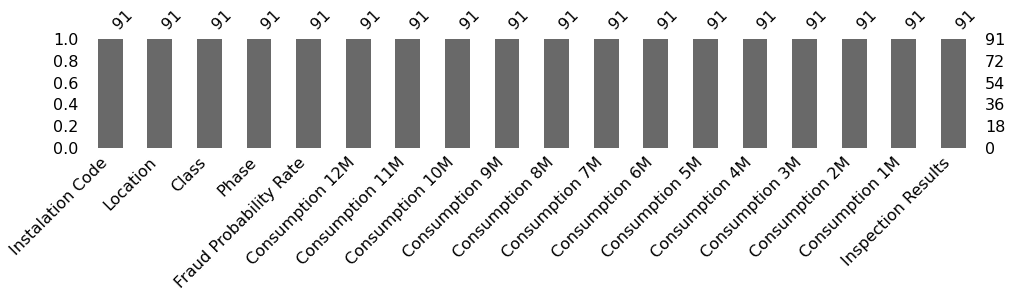

In [37]:
msno.bar(df, figsize=(16, 2))

Checking unbalanced target

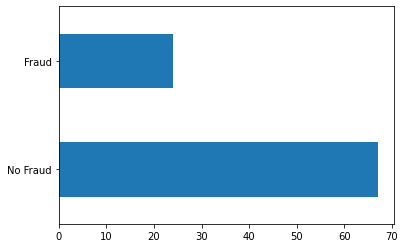

In [38]:
df['Inspection Results'].value_counts().plot.barh()

Destribution of the current score for each target

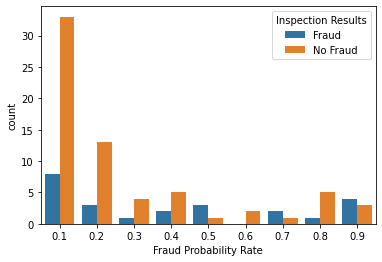

In [39]:
sns.countplot(data=df, x='Fraud Probability Rate', hue='Inspection Results')

## Cost Matrix

In order to choose the best model, our main goal is to minimize the cost of each prediction.
Each cost is depicted as follows:

- **TN - True Negative:** customers that are not considered fraudsters by the model, and they are not indeed. They do not represent any cost for the company.

- **FP - False Positive:** customers that are considered fraudsters by the model, but they are not. The cost for the company represents the cost of sending technical staff to visit the customer in addition to the branding devaluation by unhappy customers to be considered fraudsters when they are not.

- **FN - False Negative:** customers that are not considered fraudsters by the model, but they are. They represent the highest cost since they are consuming electricity without paying for it.

- **TP - True Positive:** customers that are considered fraudsters by the model, and they are indeed. The cost of the company represents the cost of sending technical staff to visit the customer

The summary of the cost for each scenario is depicted in a matrix as follows:

In [40]:
check_technical_staff = 50
unhappy_customer = 15
fraud = 200

cost_true_neg = 0
cost_false_pos = check_technical_staff + unhappy_customer
cost_false_neg = fraud
cost_true_pos = check_technical_staff

cost = np.array([[cost_true_neg, cost_false_pos],
                 [cost_false_neg, cost_true_pos]])

print(cost)

[[  0  65]
 [200  50]]


In [42]:
y = dataprep_target(df)
y_pred_0 = np.zeros(len(df), dtype='int')
y_pred_1 = np.ones(len(df), dtype='int')
y_pred_half = np.ones(34)
y_pred_half = np.append(y_pred_half, np.zeros(33))
y_pred_half = np.append(y_pred_half, np.ones(12))
y_pred_half = np.append(y_pred_half, np.zeros(12))

We can analyze the average cost per customer for a model that always predicts that customers are fraudsters

Average cost: 61.043956043956044


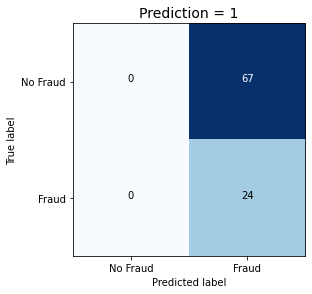

In [43]:
plot_confusion_matrix(y, y_pred_1, title='Prediction = 1')
print(f'Average cost: {average_cost(y, y_pred_1, cost)}')

Or for a model that always predicts that half of the customers are fraudsters

Average cost: 57.252747252747255


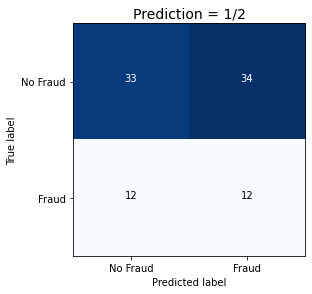

In [44]:
plot_confusion_matrix(np.sort(y), y_pred_half, title='Prediction = 1/2')
print(f'Average cost: {average_cost(np.sort(y), y_pred_half, cost)}')

Or for a model that always predicts that no customers are fraudsters

Average cost: 52.747252747252745


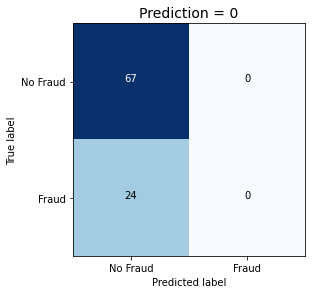

In [45]:
plot_confusion_matrix(y, y_pred_0, title='Prediction = 0')
print(f'Average cost: {average_cost(y, y_pred_0, cost)}')

According to the benchmark of dummy models, the score has to beat the average cost of `52.74$`

## Checking current model

Before modeling, we can check the performance of the current prediction score for each probability threshold, by analyzing its `roc auc score`, `accuracy`, `recall`, `precision`, and `average cost`

Threshold: 0.1 | Roc Auc:   0.5 | Accuracy:  0.26 | Recall:   1.0 | Precision:  0.26 | Avg cost: 61.04
Threshold: 0.2 | Roc Auc:  0.58 | Accuracy:  0.54 | Recall:  0.67 | Precision:  0.32 | Avg cost: 50.66
Threshold: 0.3 | Roc Auc:  0.61 | Accuracy:  0.65 | Recall:  0.54 | Precision:  0.38 | Avg cost: 46.32
Threshold: 0.4 | Roc Auc:  0.62 | Accuracy:  0.68 | Recall:   0.5 | Precision:  0.41 | Avg cost: 45.11
Threshold: 0.5 | Roc Auc:  0.62 | Accuracy:  0.71 | Recall:  0.42 | Precision:  0.45 | Avg cost: 44.84
Threshold: 0.6 | Roc Auc:  0.56 | Accuracy:  0.69 | Recall:  0.29 | Precision:  0.39 | Avg cost: 49.07
Threshold: 0.7 | Roc Auc:  0.58 | Accuracy:  0.71 | Recall:  0.29 | Precision:  0.44 | Avg cost: 47.64
Threshold: 0.8 | Roc Auc:  0.54 | Accuracy:   0.7 | Recall:  0.21 | Precision:  0.38 | Avg cost: 50.22
Threshold: 0.9 | Roc Auc:  0.56 | Accuracy:  0.75 | Recall:  0.17 | Precision:  0.57 | Avg cost: 48.3


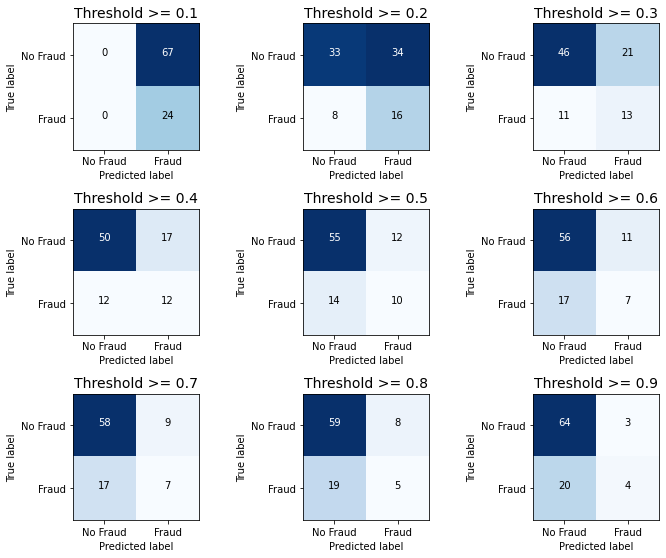

In [47]:
y_true = dataprep_target(df)
y_pred = df['Fraud Probability Rate']
change_threshold(y_true, y_pred, cost)

As we can see, the best threshold is `0.5` with the average cost of `44.84$`

## EDA (exploratory data analysis)

The dataset contains customers of different groups:
- **Cities** `Rio de Janeiro` and `Rio de Janeiro`
- **Type of client** `Residential` and `Commercial`
- **Phases** `1`, `2` and `3`

We can analyze each macro group or micro group as follows:

Column:  Location


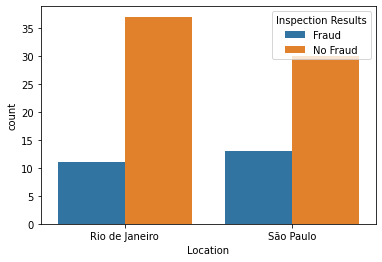

Proportion of column: Location
Rio de Janeiro    53.0
São Paulo         47.0
Name: Location, dtype: float64 

Contingency table:
Inspection Results  Fraud  No Fraud  All
Location                                
Rio de Janeiro         11        37   48
São Paulo              13        30   43
All                    24        67   91 

Normalized contingency table:
Inspection Results  Fraud  No Fraud
Location                           
Rio de Janeiro       0.23      0.77
São Paulo            0.30      0.70
All                  0.26      0.74 

Column:  Class


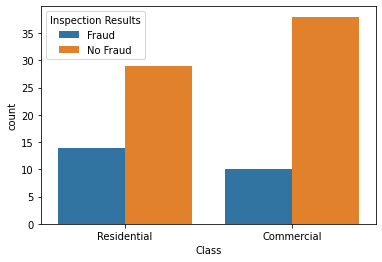

Proportion of column: Class
Commercial     53.0
Residential    47.0
Name: Class, dtype: float64 

Contingency table:
Inspection Results  Fraud  No Fraud  All
Class                                   
Commercial             10        38   48
Residential            14        29   43
All                    24        67   91 

Normalized contingency table:
Inspection Results  Fraud  No Fraud
Class                              
Commercial           0.21      0.79
Residential          0.33      0.67
All                  0.26      0.74 

Column:  Phase


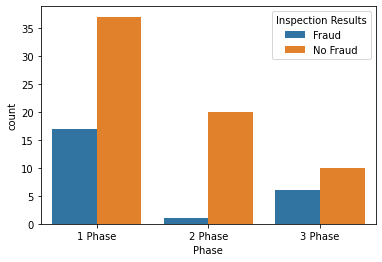

Proportion of column: Phase
1 Phase    59.0
2 Phase    23.0
3 Phase    18.0
Name: Phase, dtype: float64 

Contingency table:
Inspection Results  Fraud  No Fraud  All
Phase                                   
1 Phase                17        37   54
2 Phase                 1        20   21
3 Phase                 6        10   16
All                    24        67   91 

Normalized contingency table:
Inspection Results  Fraud  No Fraud
Phase                              
1 Phase              0.31      0.69
2 Phase              0.05      0.95
3 Phase              0.38      0.62
All                  0.26      0.74 



In [48]:
plot_partial_description(df)

Filtering: Location - Rio de Janeiro
Filtering: Class    - Residential
Filtering: Phase    - 1 Phase


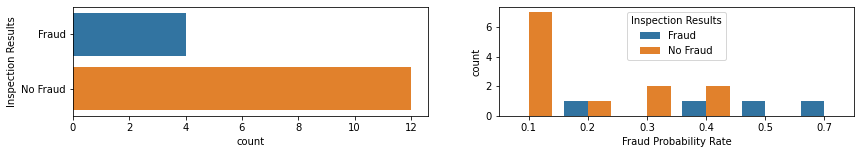

<============ Raw Data ============>


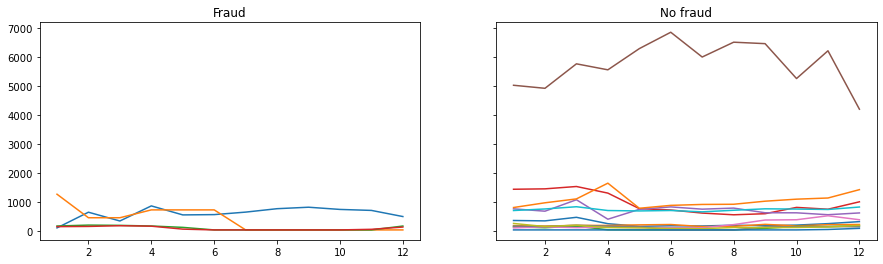

<============ Raw Data ============>


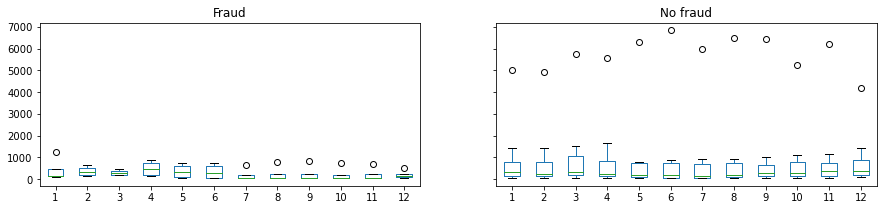

<============ Normalized Data ============>


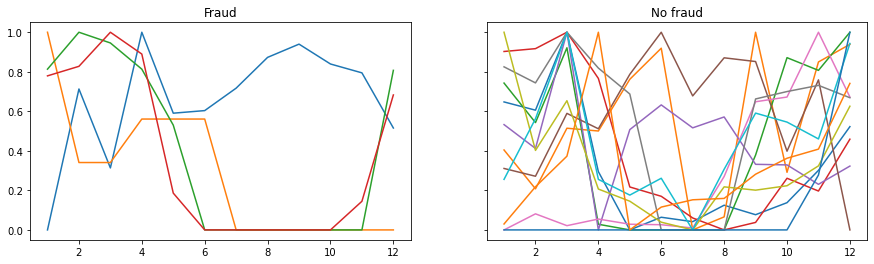

Aggregation function: mean


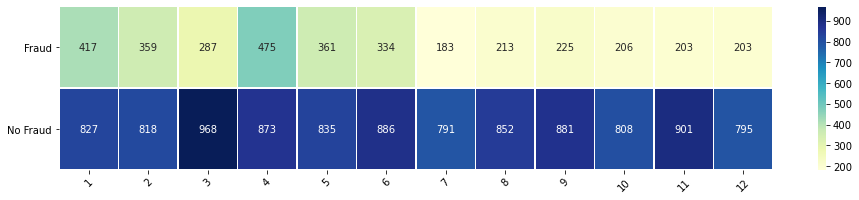

Aggregation function: median


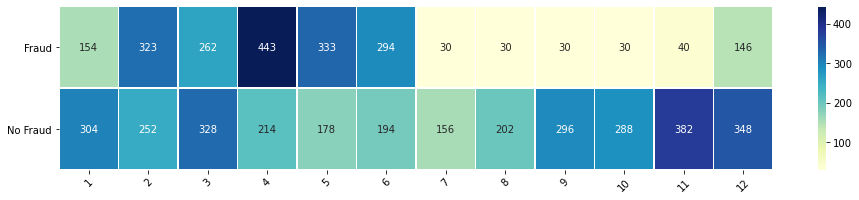

Aggregation function: std


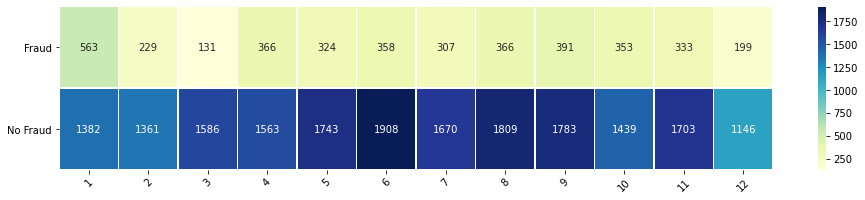

<========================================================================>
Filtering: Location - Rio de Janeiro
Filtering: Class    - Residential
Filtering: Phase    - 2 Phase


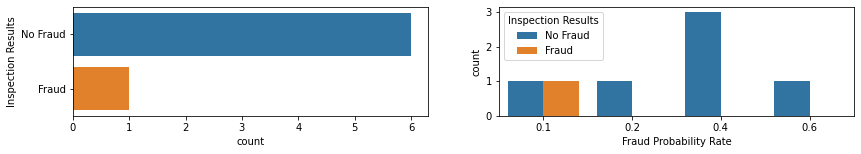

<============ Raw Data ============>


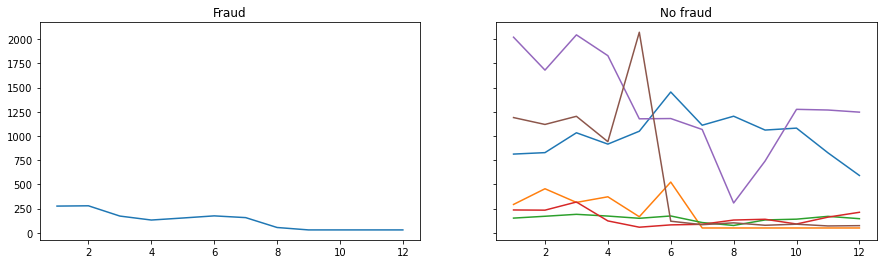

<============ Raw Data ============>


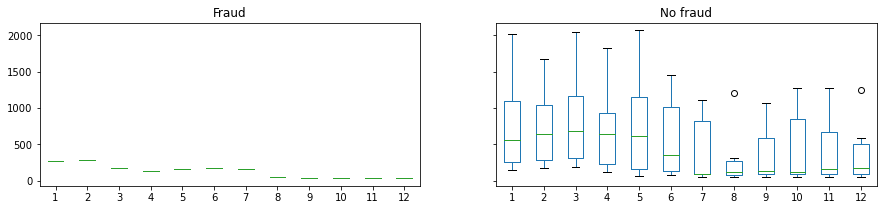

<============ Normalized Data ============>


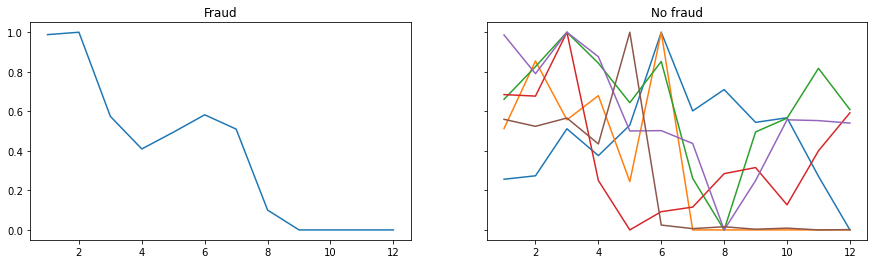

Aggregation function: mean


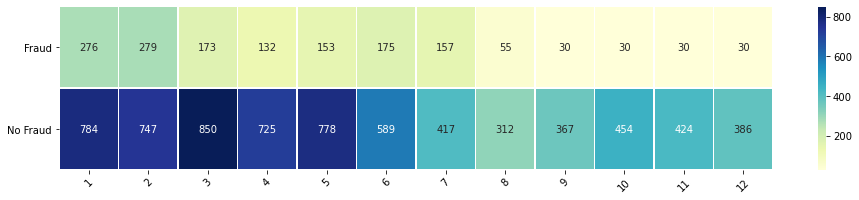

Aggregation function: median


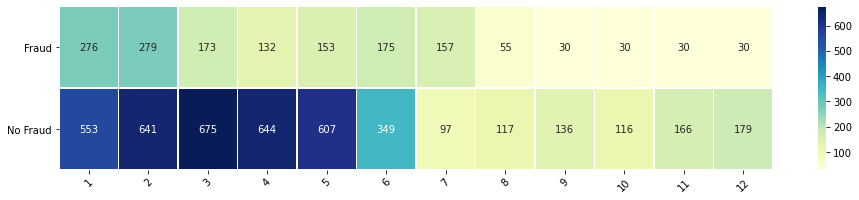

Aggregation function: std
<========================================================================>
Filtering: Location - Rio de Janeiro
Filtering: Class    - Residential
Filtering: Phase    - 3 Phase
No data
Filtering: Location - Rio de Janeiro
Filtering: Class    - Commercial
Filtering: Phase    - 1 Phase


<Figure size 1152x216 with 0 Axes>

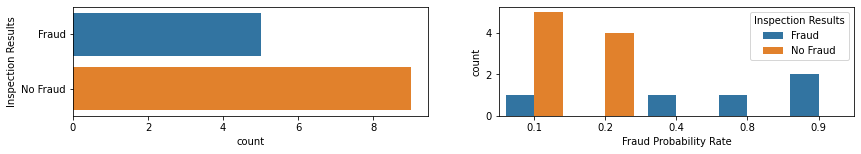

<============ Raw Data ============>


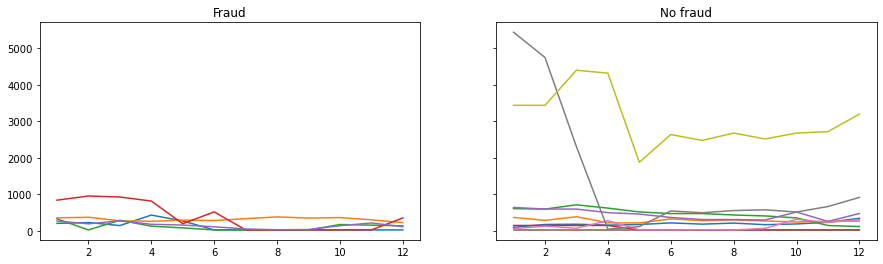

<============ Raw Data ============>


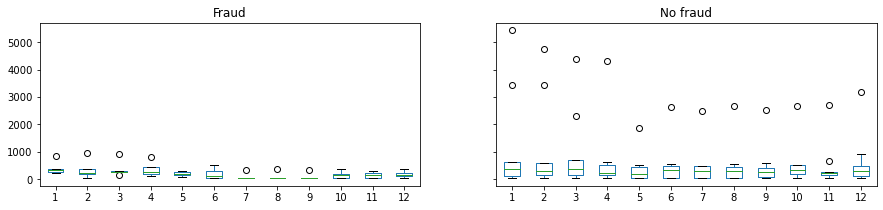

<============ Normalized Data ============>


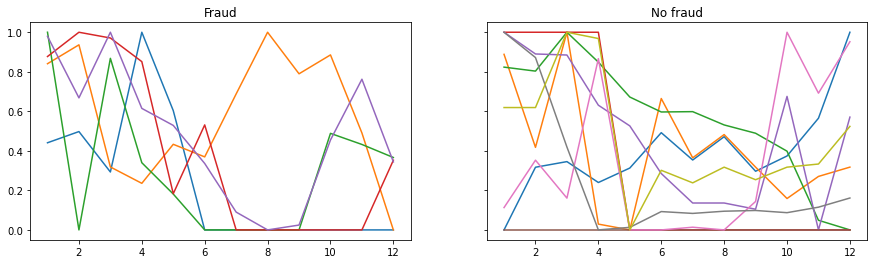

Aggregation function: mean


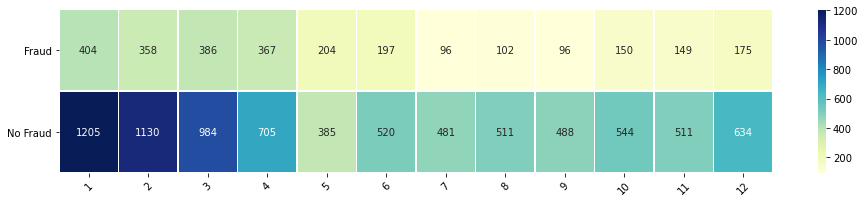

Aggregation function: median


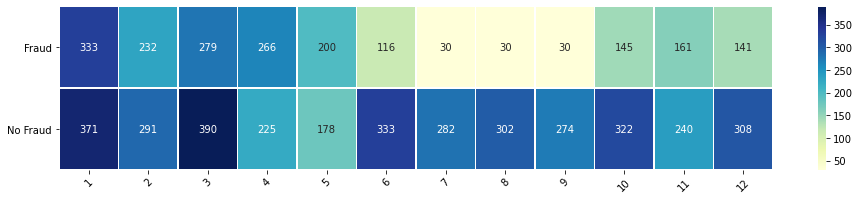

Aggregation function: std


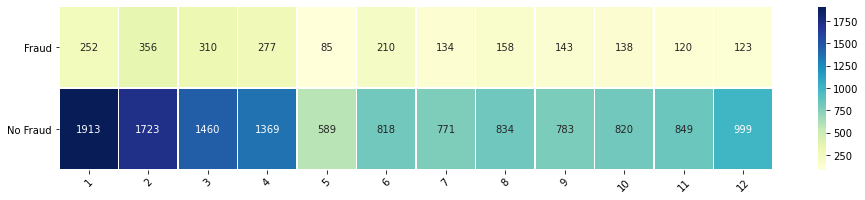

<========================================================================>
Filtering: Location - Rio de Janeiro
Filtering: Class    - Commercial
Filtering: Phase    - 2 Phase
No data
Filtering: Location - Rio de Janeiro
Filtering: Class    - Commercial
Filtering: Phase    - 3 Phase


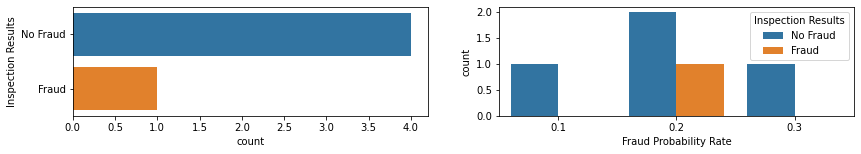

<============ Raw Data ============>


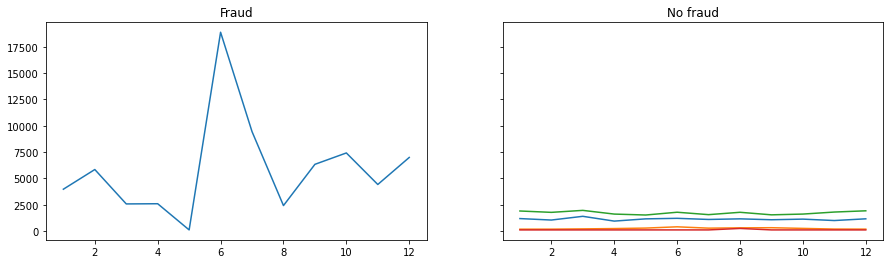

<============ Raw Data ============>


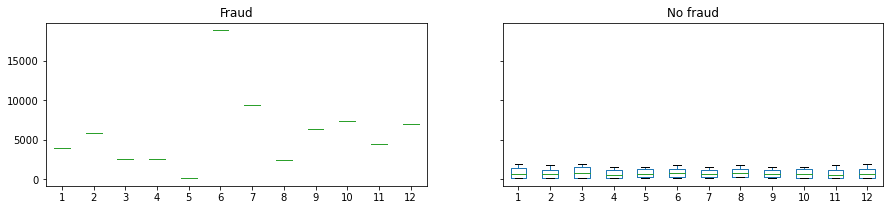

<============ Normalized Data ============>


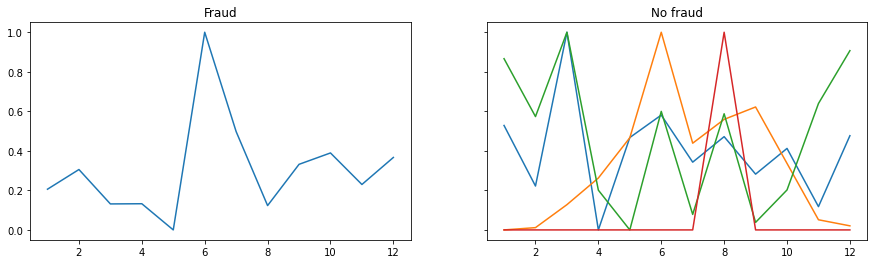

Aggregation function: mean


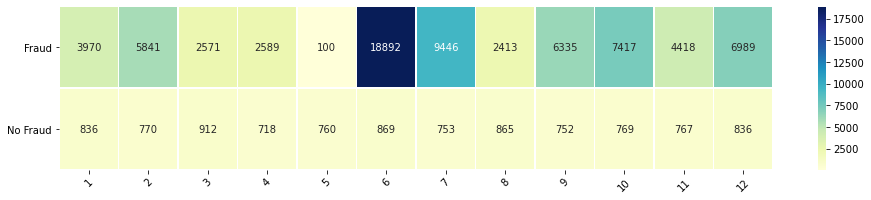

Aggregation function: median


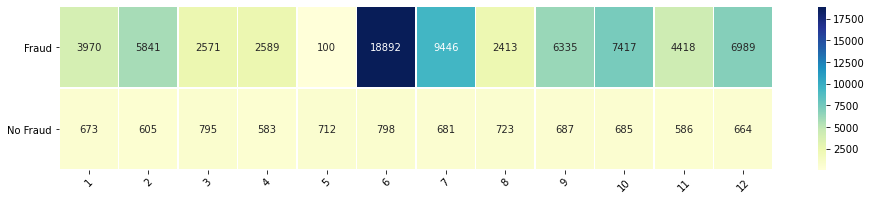

Aggregation function: std
<========================================================================>
Filtering: Location - São Paulo
Filtering: Class    - Residential
Filtering: Phase    - 1 Phase


<Figure size 1152x216 with 0 Axes>

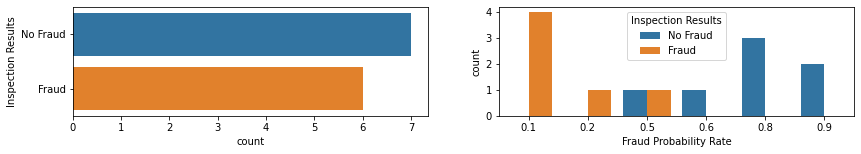

<============ Raw Data ============>


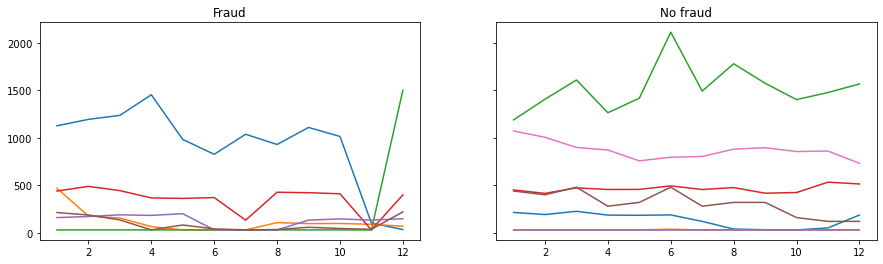

<============ Raw Data ============>


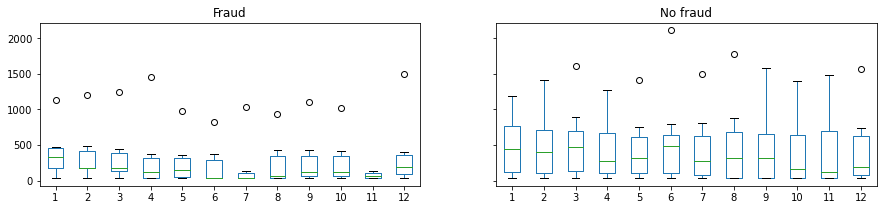

<============ Normalized Data ============>


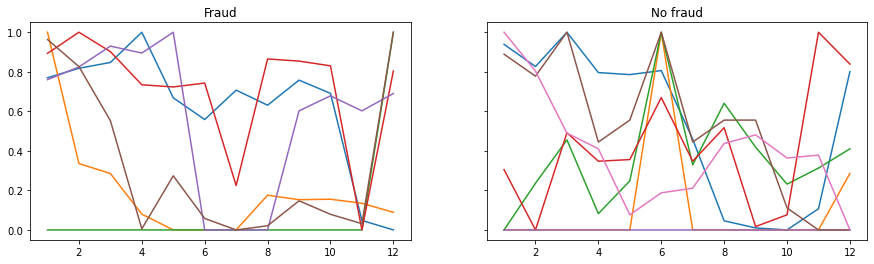

Aggregation function: mean


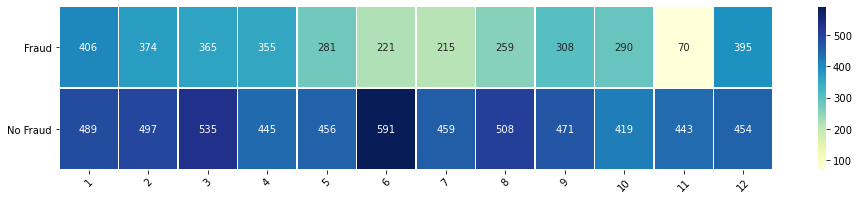

Aggregation function: median


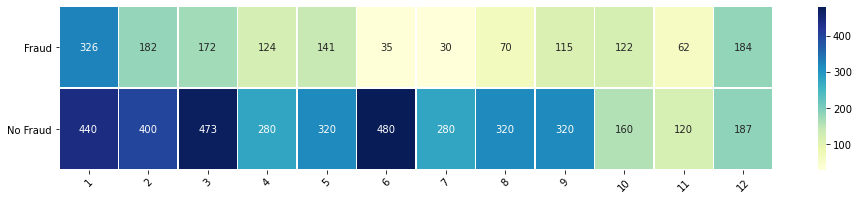

Aggregation function: std


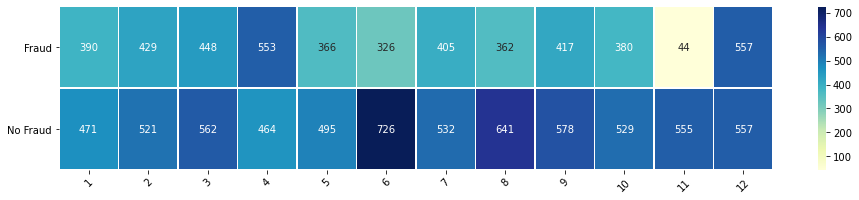

<========================================================================>
Filtering: Location - São Paulo
Filtering: Class    - Residential
Filtering: Phase    - 2 Phase
No data
Filtering: Location - São Paulo
Filtering: Class    - Residential
Filtering: Phase    - 3 Phase


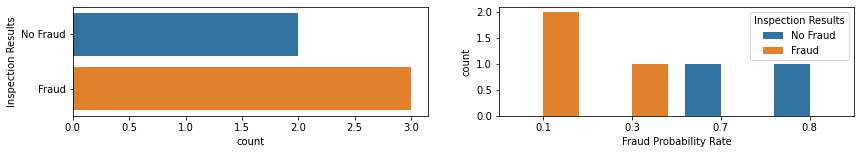

<============ Raw Data ============>


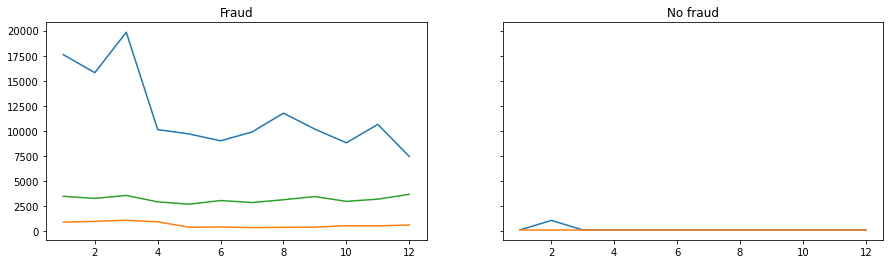

<============ Raw Data ============>


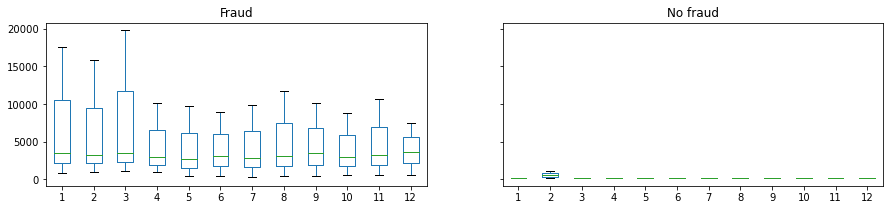

<============ Normalized Data ============>


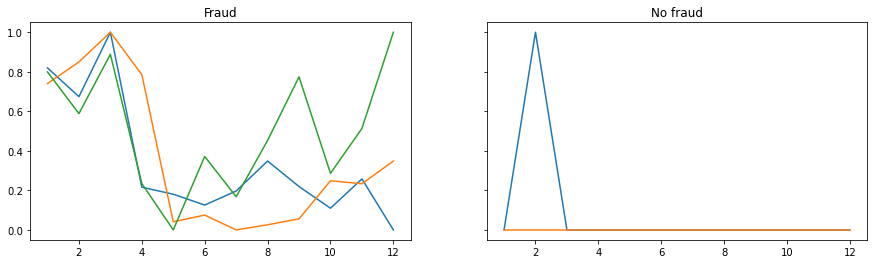

Aggregation function: mean


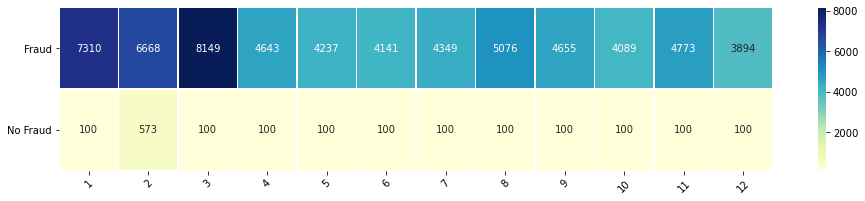

Aggregation function: median


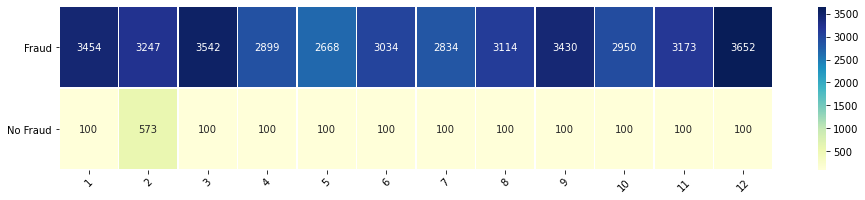

Aggregation function: std


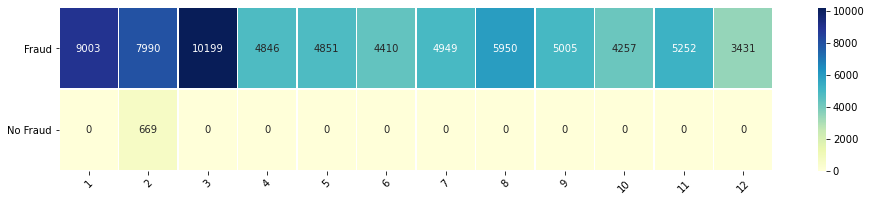

<========================================================================>
Filtering: Location - São Paulo
Filtering: Class    - Commercial
Filtering: Phase    - 1 Phase


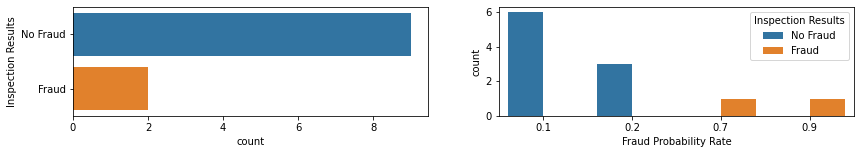

<============ Raw Data ============>


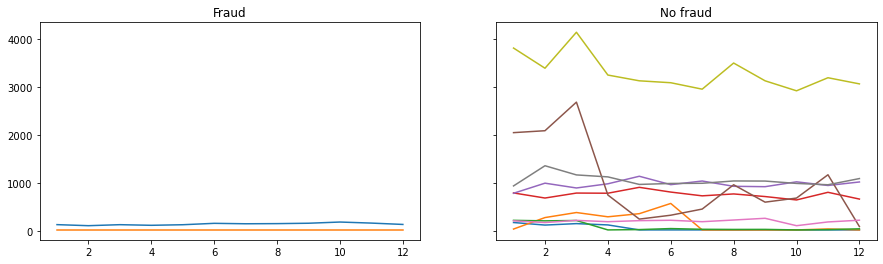

<============ Raw Data ============>


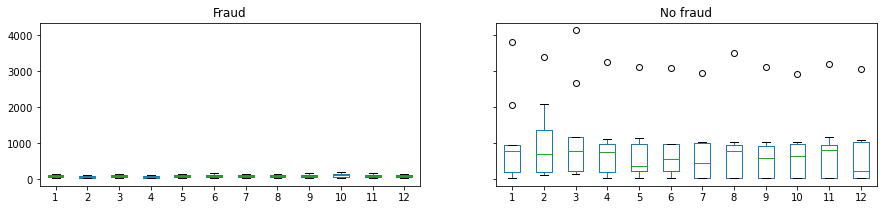

<============ Normalized Data ============>


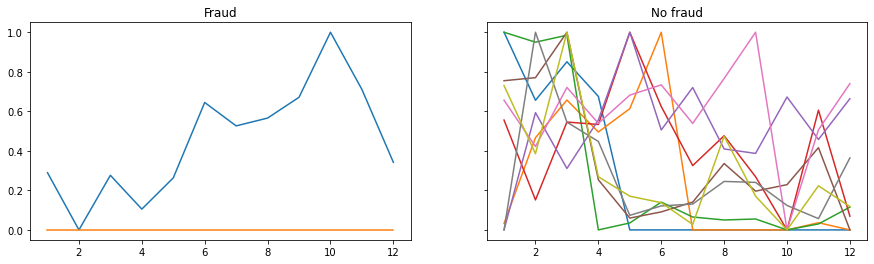

Aggregation function: mean


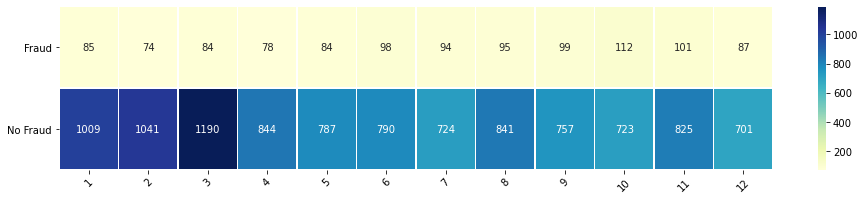

Aggregation function: median


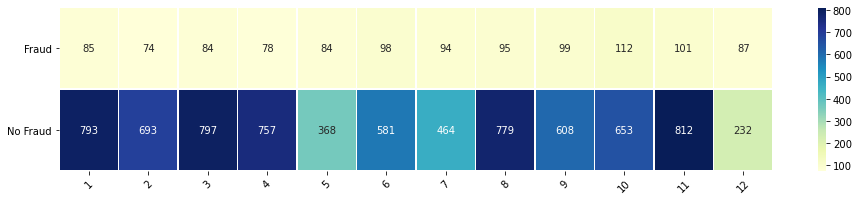

Aggregation function: std


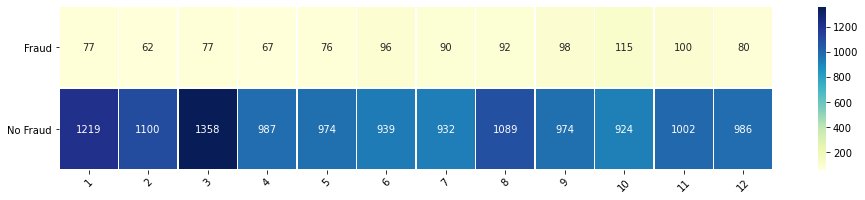

<========================================================================>
Filtering: Location - São Paulo
Filtering: Class    - Commercial
Filtering: Phase    - 2 Phase
No data
Filtering: Location - São Paulo
Filtering: Class    - Commercial
Filtering: Phase    - 3 Phase


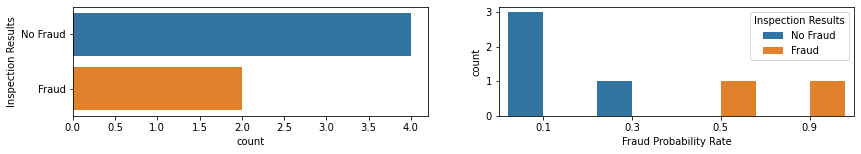

<============ Raw Data ============>


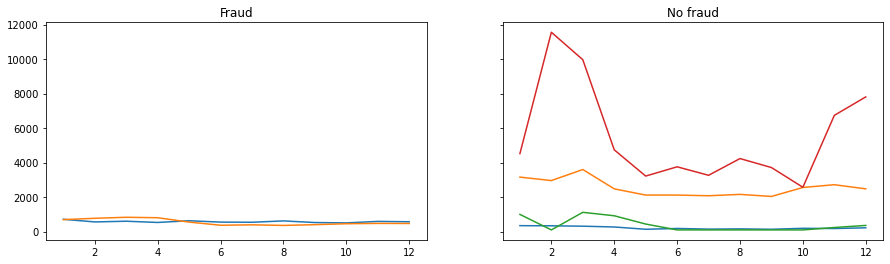

<============ Raw Data ============>


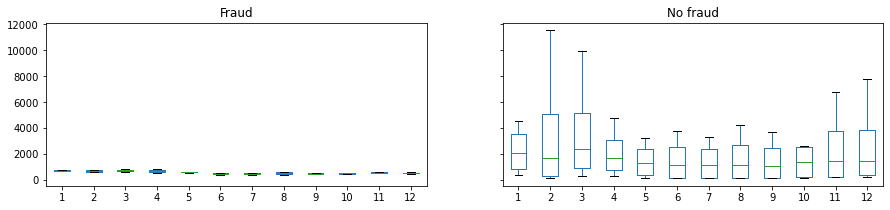

<============ Normalized Data ============>


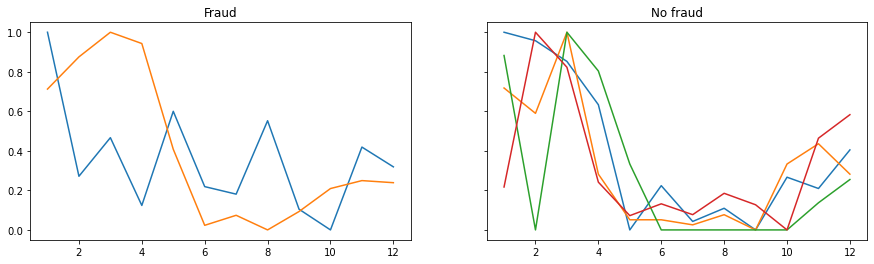

Aggregation function: mean


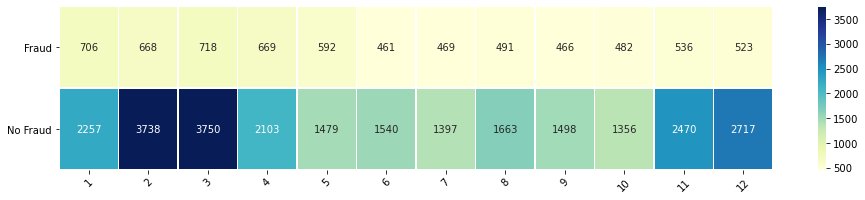

Aggregation function: median


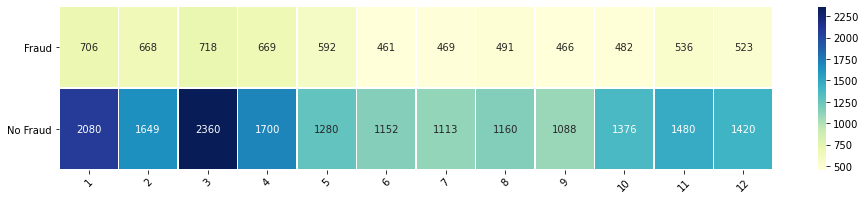

Aggregation function: std


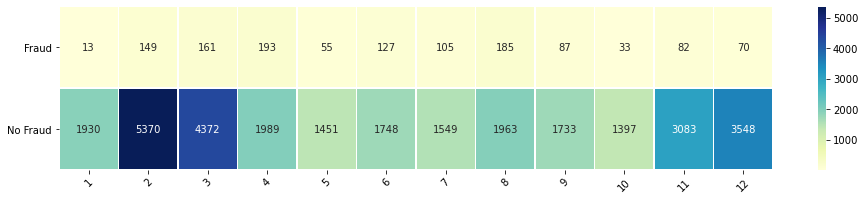

<========================================================================>


In [49]:
plot_full_description(df, 'Rio de Janeiro', 'Residential', '1 Phase')
plot_full_description(df, 'Rio de Janeiro', 'Residential', '2 Phase')
plot_full_description(df, 'Rio de Janeiro', 'Residential', '3 Phase')

plot_full_description(df, 'Rio de Janeiro', 'Commercial', '1 Phase')
plot_full_description(df, 'Rio de Janeiro', 'Commercial', '2 Phase')
plot_full_description(df, 'Rio de Janeiro', 'Commercial', '3 Phase')

plot_full_description(df, 'São Paulo', 'Residential', '1 Phase')
plot_full_description(df, 'São Paulo', 'Residential', '2 Phase')
plot_full_description(df, 'São Paulo', 'Residential', '3 Phase')

plot_full_description(df, 'São Paulo', 'Commercial', '1 Phase')
plot_full_description(df, 'São Paulo', 'Commercial', '2 Phase')
plot_full_description(df, 'São Paulo', 'Commercial', '3 Phase')

## Feature engineering

Besides using the data of electricity consumption of each month for each customer, I applied the following feature engineering techniques before modeling:

- normalizing electricity consumption for each customer
- creating feature of max frequency of a value for each customer
- adding aggregated values (mean, standard deviation, median, quartiles) for each customer
- adding categorical features as dummy features

In [50]:
df_dataprep = feat_eng_full(df)

## Modeling

In order to discriminate the data, I tried three approaches to obtain a better fraud detection score

### Classification

The rationale here is to try several simple classifiers (`Logistic Regression`, `KNN`, `Decision Tree`, `Random Forest`, `AdaBoost` and `SVM`) combined samplers (`Random Under Sampler` and `Random Over Sampler`) to discriminate fraudster from the dataset

In [51]:
classifiers = {'Logistic Regression': LogisticRegression(),
               'KNN': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
               'Random Forest': RandomForestClassifier(class_weight='balanced'),
               'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced')),
               'SVM': SVC()}

samplers = {'Random_under_sampler': RandomUnderSampler(),
            'Random_over_sampler': RandomOverSampler()}

In [52]:
df_test, df_cv_roc, df_cv_acc, df_cv_rec, df_cv_pre = train_clfs(df_dataprep, classifiers, samplers)

Sampler: Random_under_sampler
Classifier: Logistic Regression

CV	-	roc_auc:	0.432
CV	-	accuracy:	0.619
CV	-	recall:		0.595
CV	-	precision:	0.333
Test	-	roc_auc:	0.69
Test	-	accuracy:	0.607
Test	-	recall:		0.857
Test	-	precision:	0.375

<-------------------------->

Classifier: KNN

CV	-	roc_auc:	0.573
CV	-	accuracy:	0.54
CV	-	recall:		0.429
CV	-	precision:	0.152
Test	-	roc_auc:	0.5
Test	-	accuracy:	0.464
Test	-	recall:		0.571
Test	-	precision:	0.25

<-------------------------->

Classifier: Decision Tree

CV	-	roc_auc:	0.594
CV	-	accuracy:	0.619
CV	-	recall:		0.476
CV	-	precision:	0.398
Test	-	roc_auc:	0.405
Test	-	accuracy:	0.464
Test	-	recall:		0.286
Test	-	precision:	0.167

<-------------------------->

Classifier: Random Forest

CV	-	roc_auc:	0.67
CV	-	accuracy:	0.714
CV	-	recall:		0.69
CV	-	precision:	0.476
Test	-	roc_auc:	0.405
Test	-	accuracy:	0.464
Test	-	recall:		0.286
Test	-	precision:	0.167

<-------------------------->

Classifier: AdaBoost

CV	-	roc_auc:	0.583
CV	-	accura

For each model and sampler, we can check its metrics for cross validation and testset

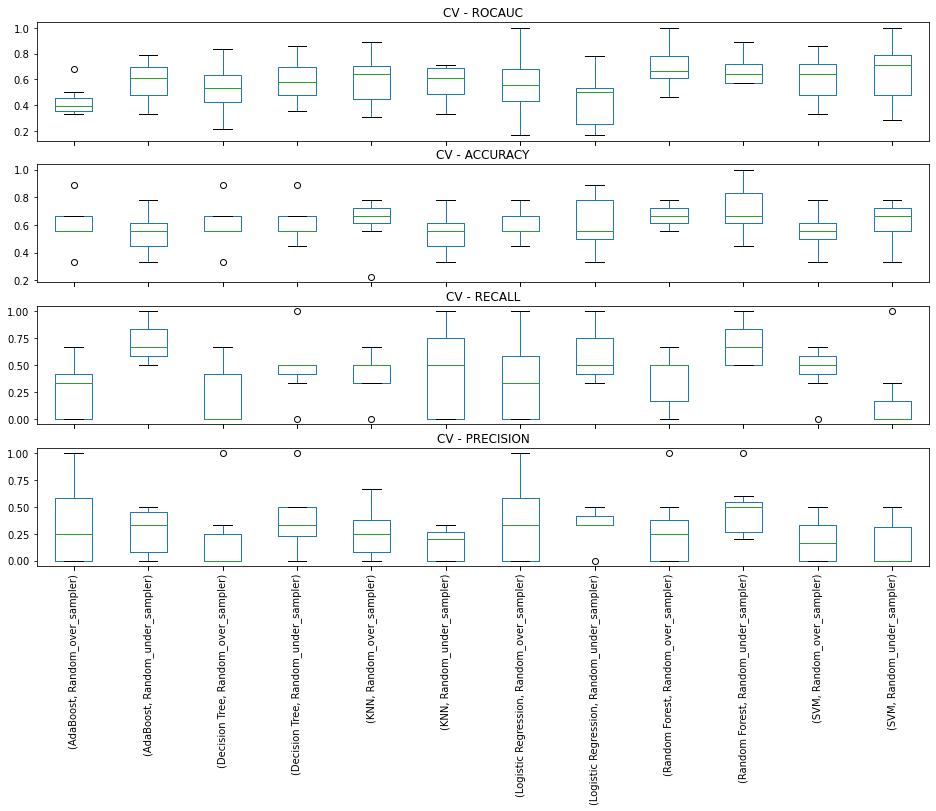

In [53]:
plot_boxplot_metrics(df_cv_roc, df_cv_acc, df_cv_rec, df_cv_pre)

As we can see, `Logistic Regression` seems to perform well on the testset

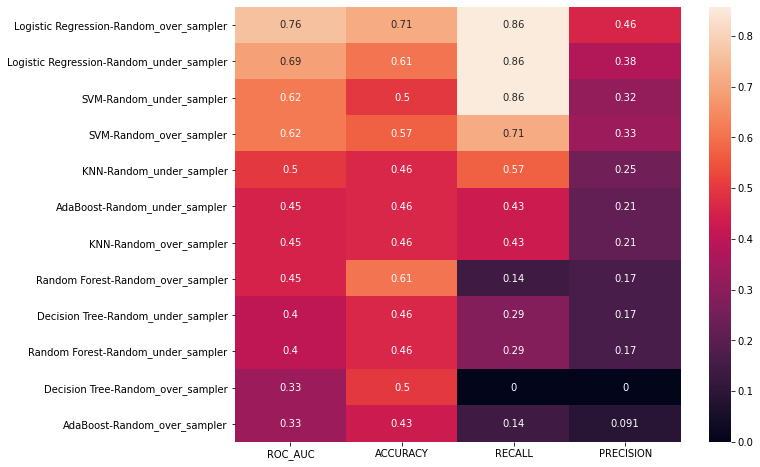

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_test, annot=True, fmt='.2g')
plt.ylabel('')
plt.show()

### Tuning classifiers

I will try tuning hyperparameters of some classifiers to analyze whether they can get any better

In [55]:
param_grid_lr = [{'clf':[LogisticRegression()],
                  'clf__penalty': ['l1', 'l2', 'elasticnet'],
                  'clf__C' : np.logspace(-4, 4, 20)}]

Best parameters: {'clf': LogisticRegression(C=11.288378916846883, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'clf__C': 11.288378916846883, 'clf__penalty': 'l2'}

Best CV score: 0.738
Roc Auc: 0.738 | Accuracy: 0.679 | Recall: 0.857 | Precision: 0.429 | Avg cost: 36.429


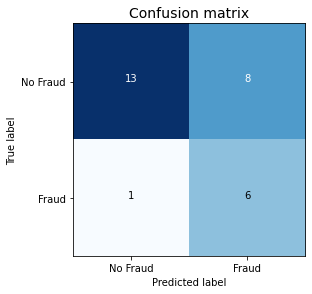

In [59]:
grid_lr = train_clf_tuning(df_dataprep, LogisticRegression(),
                           param_grid_lr, cost, RandomUnderSampler())

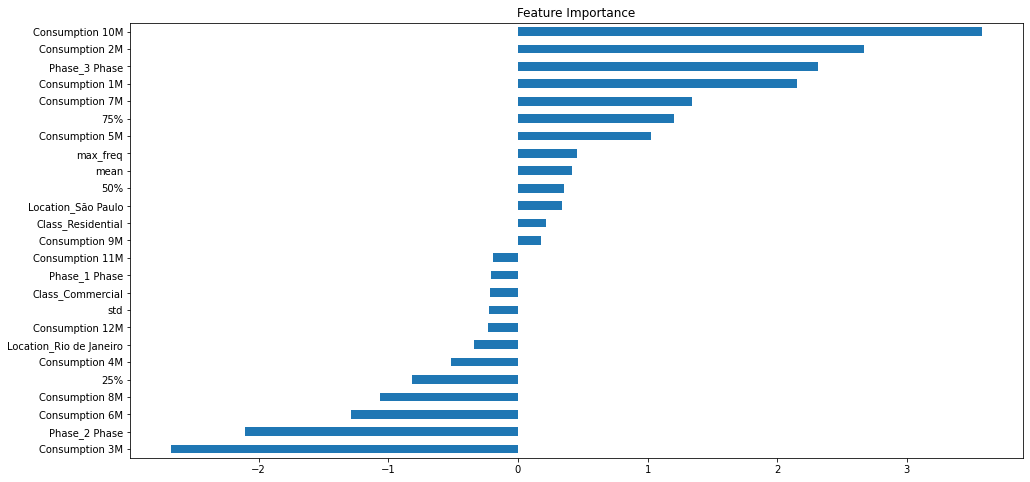

In [60]:
pd.DataFrame(grid_lr['clf'].coef_,
             columns=df_dataprep.columns[:-1],
             index=['coef']).T.sort_values('coef').plot.barh(figsize=(16,8), title='Feature Importance', legend=False)
plt.show()

Best parameters: {'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'clf__max_depth': 15, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}

Best CV score: 0.5
Roc Auc: 0.405 | Accuracy: 0.536 | Recall: 0.143 | Precision: 0.125 | Avg cost: 60.893


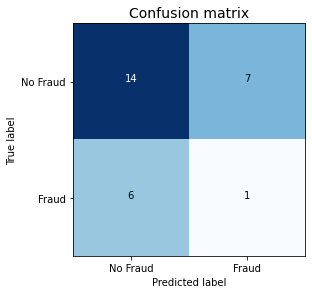

In [62]:
param_grid_rf = [{'clf':[RandomForestClassifier()],
                  'clf__max_depth': np.arange(5, 30, 2),
                  'clf__n_estimators': np.arange(100, 400, 100),
                  'clf__min_samples_split': [4, 5, 7]}]

grid_rf = train_clf_tuning(df_dataprep, 
                           RandomForestClassifier(class_weight='balanced'),
                           param_grid_rf, cost, RandomOverSampler())

Best parameters: {'clf': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'clf__C': 1, 'clf__degree': 3, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}

Best CV score: 0.791
Roc Auc: 0.524 | Accuracy: 0.571 | Recall: 0.429 | Precision: 0.273 | Avg cost: 52.5


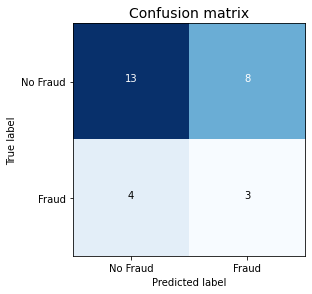

In [63]:
param_grid_svm = [{'clf':[SVC()],
                   'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                   'clf__degree': np.arange(2, 10, 1),
                   'clf__gamma': [0.1, 1, 10, 100],
                   'clf__C': [0.1, 1, 10, 100, 1000]}]

grid_svm = train_clf_tuning(df_dataprep, SVC(), param_grid_svm, cost, RandomOverSampler(), scoring='roc_auc')

Best parameters: {'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform'), 'clf__metric': 'euclidean', 'clf__n_neighbors': 7, 'clf__weights': 'uniform'}

Best CV score: 0.643
Roc Auc: 0.619 | Accuracy: 0.571 | Recall: 0.714 | Precision: 0.333 | Avg cost: 46.429


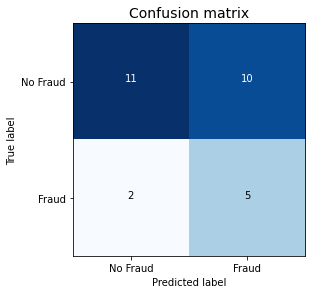

In [64]:
param_grid_knn = [{'clf':[KNeighborsClassifier()],
                   'clf__n_neighbors': np.arange(5, 25, 1),
                   'clf__weights': ['uniform', 'distance'],
                   'clf__metric': ['euclidean', 'manhattan']}]

grid_knn = train_clf_tuning(df_dataprep, KNeighborsClassifier(),
                            param_grid_knn, cost, RandomUnderSampler())

Among the tuned `Logistic Regression`, `KNN`, `Random Forest`, and `SVM`, the first one seems to be the best with an average cost of `36.43$`

### Anomaly detection

Some unsupervised algorithms such as `Isolation Forest`, `Local Outlier Factor`, and `One Class SVM` are commonly applied for outlier detection. I try them to identify the fraudster from the dataset

In [65]:
models_ad = {'Isolation Forest': IsolationForest(random_state=42),
             'Local Outlier Factor': LocalOutlierFactor(n_neighbors=18, novelty=True),
             'One Class SVM': OneClassSVM()}

Model: Isolation Forest

Threshold: 0.1 | Roc Auc:  0.52 | Accuracy:  0.29 | Recall:   1.0 | Precision:  0.26 | Avg cost: 58.93
Threshold: 0.2 | Roc Auc:  0.52 | Accuracy:  0.29 | Recall:   1.0 | Precision:  0.26 | Avg cost: 58.93
Threshold: 0.3 | Roc Auc:  0.67 | Accuracy:   0.5 | Recall:   1.0 | Precision:  0.33 | Avg cost: 45.0
Threshold: 0.4 | Roc Auc:  0.55 | Accuracy:  0.46 | Recall:  0.71 | Precision:  0.28 | Avg cost: 53.39
Threshold: 0.5 | Roc Auc:   0.6 | Accuracy:  0.54 | Recall:  0.71 | Precision:  0.31 | Avg cost: 48.75
Threshold: 0.6 | Roc Auc:  0.64 | Accuracy:  0.75 | Recall:  0.43 | Precision:   0.5 | Avg cost: 40.89
Threshold: 0.7 | Roc Auc:  0.55 | Accuracy:  0.75 | Recall:  0.14 | Precision:   0.5 | Avg cost: 46.96
Threshold: 0.8 | Roc Auc:  0.48 | Accuracy:  0.71 | Recall:   0.0 | Precision:   0.0 | Avg cost: 52.32
Threshold: 0.9 | Roc Auc:  0.48 | Accuracy:  0.71 | Recall:   0.0 | Precision:   0.0 | Avg cost: 52.32


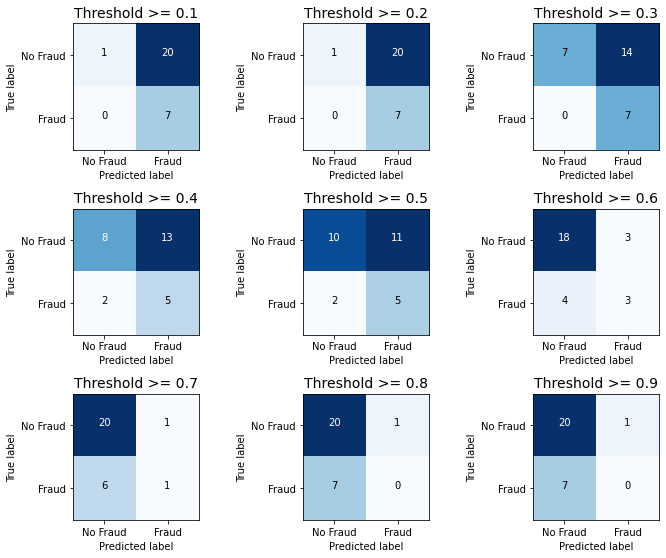

Model: Local Outlier Factor

Threshold: 0.1 | Roc Auc:  0.57 | Accuracy:  0.36 | Recall:   1.0 | Precision:  0.28 | Avg cost: 54.29
Threshold: 0.2 | Roc Auc:  0.57 | Accuracy:  0.36 | Recall:   1.0 | Precision:  0.28 | Avg cost: 54.29
Threshold: 0.3 | Roc Auc:  0.57 | Accuracy:  0.36 | Recall:   1.0 | Precision:  0.28 | Avg cost: 54.29
Threshold: 0.4 | Roc Auc:   0.6 | Accuracy:  0.39 | Recall:   1.0 | Precision:  0.29 | Avg cost: 51.96
Threshold: 0.5 | Roc Auc:   0.6 | Accuracy:  0.39 | Recall:   1.0 | Precision:  0.29 | Avg cost: 51.96
Threshold: 0.6 | Roc Auc:   0.6 | Accuracy:  0.39 | Recall:   1.0 | Precision:  0.29 | Avg cost: 51.96
Threshold: 0.7 | Roc Auc:   0.5 | Accuracy:  0.39 | Recall:  0.71 | Precision:  0.25 | Avg cost: 58.04
Threshold: 0.8 | Roc Auc:  0.52 | Accuracy:  0.43 | Recall:  0.71 | Precision:  0.26 | Avg cost: 55.71
Threshold: 0.9 | Roc Auc:  0.45 | Accuracy:  0.46 | Recall:  0.43 | Precision:  0.21 | Avg cost: 59.46


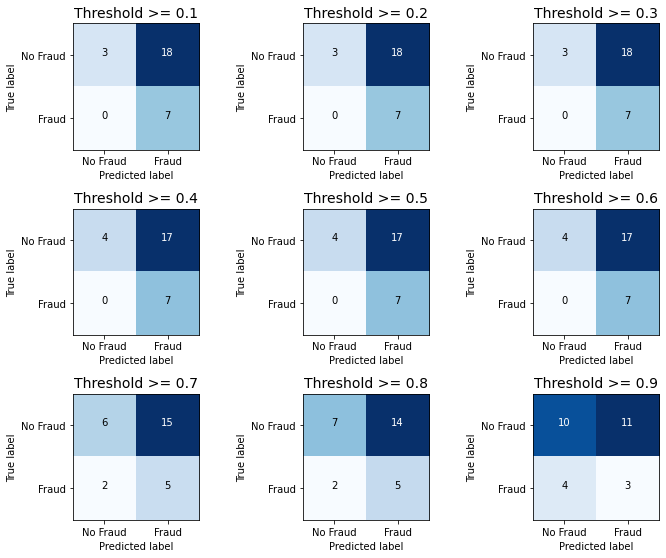

Model: One Class SVM

Threshold: 0.1 | Roc Auc:  0.57 | Accuracy:  0.36 | Recall:   1.0 | Precision:  0.28 | Avg cost: 54.29
Threshold: 0.2 | Roc Auc:   0.6 | Accuracy:  0.39 | Recall:   1.0 | Precision:  0.29 | Avg cost: 51.96
Threshold: 0.3 | Roc Auc:   0.6 | Accuracy:  0.39 | Recall:   1.0 | Precision:  0.29 | Avg cost: 51.96
Threshold: 0.4 | Roc Auc:   0.6 | Accuracy:  0.39 | Recall:   1.0 | Precision:  0.29 | Avg cost: 51.96
Threshold: 0.5 | Roc Auc:   0.6 | Accuracy:  0.39 | Recall:   1.0 | Precision:  0.29 | Avg cost: 51.96
Threshold: 0.6 | Roc Auc:  0.52 | Accuracy:  0.36 | Recall:  0.86 | Precision:  0.26 | Avg cost: 57.32
Threshold: 0.7 | Roc Auc:   0.5 | Accuracy:  0.39 | Recall:  0.71 | Precision:  0.25 | Avg cost: 58.04
Threshold: 0.8 | Roc Auc:  0.52 | Accuracy:  0.43 | Recall:  0.71 | Precision:  0.26 | Avg cost: 55.71
Threshold: 0.9 | Roc Auc:  0.55 | Accuracy:  0.46 | Recall:  0.71 | Precision:  0.28 | Avg cost: 53.39


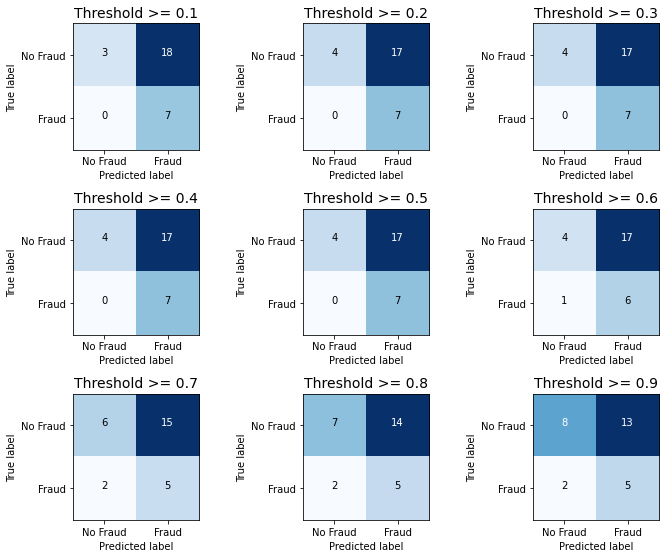

In [68]:
train_anomaly_detection(df_dataprep, models_ad, cost)

Among the anomaly detection algorithms, `Isolation Forest` with threshold of `0.6` is the best model with an average cost of `40.89$`

### LSTM

`Long Short Term Memory` is a type of recurrent neural network that considers values over time in order to predict outcomes. I tested whether the LSTM could detect changes in behavior that may help identifying fraudsters

W0407 09:52:35.182999  6588 deprecation.py:323] From C:\Users\milto\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0407 09:52:35.981445  6588 deprecation_wrapper.py:119] From C:\Users\milto\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 44 samples, validate on 19 samples
Epoch 1/100
 - 1s - loss: 0.7212 - binary_accuracy: 0.7273 - k_recall: 0.1667 - k_precision: 0.5000 - k_f1: 0.2500 - val_loss: 0.6487 - val_binary_accuracy: 0.3684 - val_k_recall: 0.0000e+00 - val_k_precision: 0.0000e+00 - val_k_f1: 0.0000e+00
Epoch 2/100
 - 0s - loss: 0.7200 - binary_accuracy: 0.6591 - k_recall: 0.3500 - k_precision: 0.6818 - k_f1: 0.3772 - val_loss: 0.6492 - val_binary_accuracy: 0.2105 - val_k_recall: 0.7500 - val_k_precision: 0.1765 - val_k_f1: 0.2857
Epoch 3/100
 - 0s - loss: 0.7198 - binary_accuracy: 0.2955 - k_recall: 0.8182 - k_precision: 0.2292 - k_f1: 0.3429 - val_loss: 0.6499 - val_binary_accuracy: 0.2105 - val_k_recall: 1.0000 - val_k_precision: 0.2105 - val_k_f1: 0.3478
Epoch 4/100
 - 0s - loss: 0.7191 - binary_accuracy: 0.2955 - k_recall: 1.0000 - k_precision: 0.2552 - k_f1: 0.3987 - val_loss: 0.6503 - val_binary_accuracy: 0.2105 - val_k_recall: 1.0000 - val_k_precision: 0.2105 - val_k_f1: 0.3478
Epoch 5/100
 - 0

Epoch 36/100
 - 0s - loss: 0.7127 - binary_accuracy: 0.3182 - k_recall: 1.0000 - k_precision: 0.3118 - k_f1: 0.4750 - val_loss: 0.6585 - val_binary_accuracy: 0.2105 - val_k_recall: 1.0000 - val_k_precision: 0.2105 - val_k_f1: 0.3478
Epoch 37/100
 - 0s - loss: 0.7126 - binary_accuracy: 0.3182 - k_recall: 1.0000 - k_precision: 0.3118 - k_f1: 0.4750 - val_loss: 0.6587 - val_binary_accuracy: 0.2105 - val_k_recall: 1.0000 - val_k_precision: 0.2105 - val_k_f1: 0.3478
Epoch 38/100
 - 0s - loss: 0.7125 - binary_accuracy: 0.3182 - k_recall: 1.0000 - k_precision: 0.2608 - k_f1: 0.4048 - val_loss: 0.6590 - val_binary_accuracy: 0.2105 - val_k_recall: 1.0000 - val_k_precision: 0.2105 - val_k_f1: 0.3478
Epoch 39/100
 - 0s - loss: 0.7118 - binary_accuracy: 0.3182 - k_recall: 0.9500 - k_precision: 0.2802 - k_f1: 0.4308 - val_loss: 0.6590 - val_binary_accuracy: 0.2105 - val_k_recall: 1.0000 - val_k_precision: 0.2105 - val_k_f1: 0.3478
Epoch 40/100
 - 0s - loss: 0.7116 - binary_accuracy: 0.3182 - k_reca

Epoch 72/100
 - 0s - loss: 0.6827 - binary_accuracy: 0.5682 - k_recall: 0.9000 - k_precision: 0.4318 - k_f1: 0.5833 - val_loss: 0.6551 - val_binary_accuracy: 0.4737 - val_k_recall: 0.7500 - val_k_precision: 0.2500 - val_k_f1: 0.3750
Epoch 73/100
 - 0s - loss: 0.6797 - binary_accuracy: 0.5909 - k_recall: 0.8889 - k_precision: 0.4607 - k_f1: 0.6050 - val_loss: 0.6515 - val_binary_accuracy: 0.4737 - val_k_recall: 0.7500 - val_k_precision: 0.2500 - val_k_f1: 0.3750
Epoch 74/100
 - 0s - loss: 0.6776 - binary_accuracy: 0.5909 - k_recall: 0.8750 - k_precision: 0.4148 - k_f1: 0.5625 - val_loss: 0.6531 - val_binary_accuracy: 0.4737 - val_k_recall: 0.7500 - val_k_precision: 0.2500 - val_k_f1: 0.3750
Epoch 75/100
 - 0s - loss: 0.6796 - binary_accuracy: 0.5909 - k_recall: 0.9091 - k_precision: 0.3810 - k_f1: 0.5312 - val_loss: 0.6544 - val_binary_accuracy: 0.4737 - val_k_recall: 0.7500 - val_k_precision: 0.2500 - val_k_f1: 0.3750
Epoch 76/100
 - 0s - loss: 0.6753 - binary_accuracy: 0.5909 - k_reca

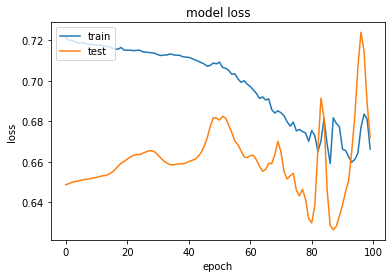

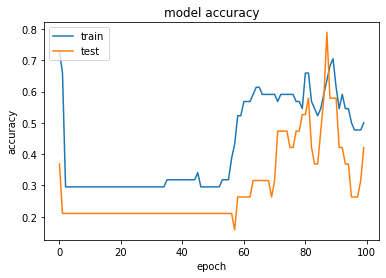

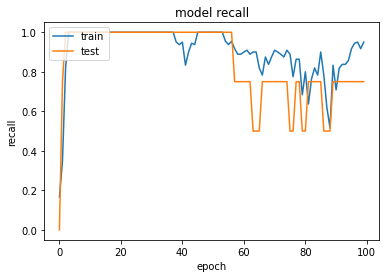

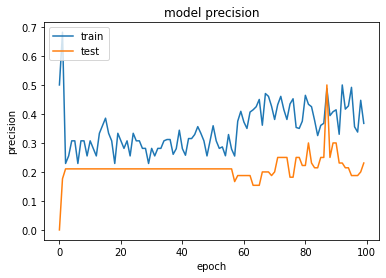

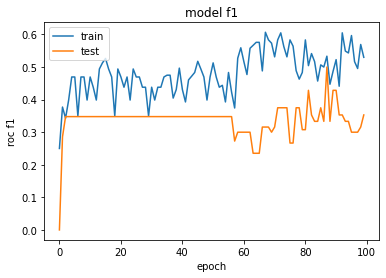

Threshold: 0.1 | Roc Auc:   0.5 | Accuracy:  0.25 | Recall:   1.0 | Precision:  0.25 | Avg cost: 61.25
Threshold: 0.2 | Roc Auc:   0.5 | Accuracy:  0.25 | Recall:   1.0 | Precision:  0.25 | Avg cost: 61.25
Threshold: 0.3 | Roc Auc:   0.5 | Accuracy:  0.25 | Recall:   1.0 | Precision:  0.25 | Avg cost: 61.25
Threshold: 0.4 | Roc Auc:   0.5 | Accuracy:  0.25 | Recall:   1.0 | Precision:  0.25 | Avg cost: 61.25
Threshold: 0.5 | Roc Auc:  0.57 | Accuracy:  0.36 | Recall:   1.0 | Precision:  0.28 | Avg cost: 54.29
Threshold: 0.6 | Roc Auc:  0.52 | Accuracy:   0.5 | Recall:  0.57 | Precision:  0.27 | Avg cost: 54.11
Threshold: 0.7 | Roc Auc:  0.48 | Accuracy:  0.71 | Recall:   0.0 | Precision:   0.0 | Avg cost: 52.32
Threshold: 0.8 | Roc Auc:   0.5 | Accuracy:  0.75 | Recall:   0.0 | Precision:   0.0 | Avg cost: 50.0
Threshold: 0.9 | Roc Auc:   0.5 | Accuracy:  0.75 | Recall:   0.0 | Precision:   0.0 | Avg cost: 50.0


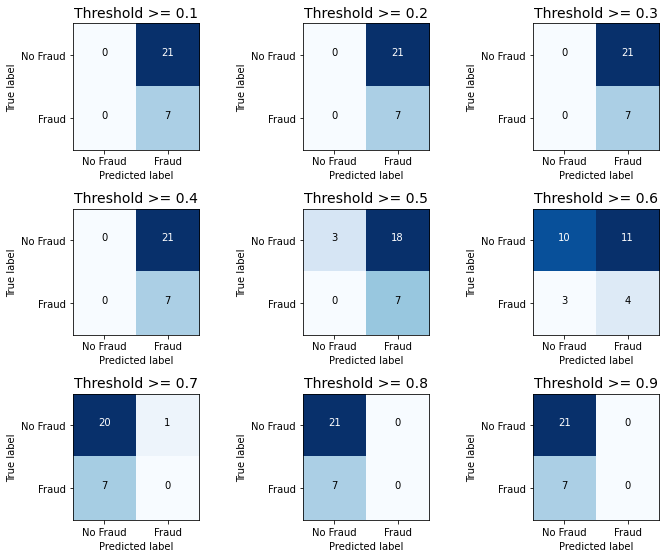

In [70]:
model_lstm = train_lstm(df_dataprep, cost)

Unfortunately, the `LSTM` failed to identify fraud electricity consumption in comparison with the previous models. The small number of cases in the dataset may have affected negatively its performance

## Results

The best average cost of the current model is `44.84$` and the best model is `Logistic Regression + Random Under Sampler` with an average cost of `36.43$`.

Choosing the new model results in a cost reduction of `8.41$` for each customer.